# ANTISOCIAL BEHAVIOUR AUDIO CLASSIFICATION

### The subject of this project is the detection of antisocial behavior based on sound data. Specifically, we are working with the UrbanSound8K dataset, which contains audio recordings of urban sounds, including sounds that could be associated with antisocial behavior such as car horns, gunshots, and screaming. Our goal is to develop a machine learning model that can accurately classify audio recordings as either containing or not containing antisocial behavior.

### To accomplish this, we will need to perform several steps, including exploratory data analysis (EDA) to gain insights into the characteristics of the dataset, preprocessing the audio data to prepare it for model training, and finally, training and evaluating several machine learning models to determine which one performs the best.

### In the following code, we start by importing the necessary libraries and loading the metadata for the UrbanSound8K dataset. We then perform some basic EDA by visualizing the distribution of sound classes in the dataset, as well as checking for missing values in the metadata. We also define some helper functions for extracting audio metadata and computing audio statistics. These functions will be useful later in the project when we preprocess the audio data.

## URBAN8K DATASET

8732 audio files of urban sounds in WAV format.


This data.csv file contains meta-data information about every audio file in the dataset. This includes:

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* classID:
A numeric identifier of the sound class:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

* class:
The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music.

## 1 - EDA

First, the necessary libraries are imported including pandas, numpy, matplotlib, seaborn, librosa, IPython.display, os, and scipy.io. These libraries are essential for data processing, data visualization, and audio processing.

Next, the metadata from the Urban8K dataset is read in from a CSV file using the pd.read_csv method and stored in a pandas DataFrame. The class distribution of the dataset is then plotted using a bar chart created with matplotlib. This gives an idea of the distribution of the classes in the dataset, which is important to understand in order to make informed decisions about the classification model.

The create_dataset_df function is defined to create a DataFrame containing the filepaths of the audio files. This function reads in the metadata DataFrame, extracts the fold number and the slice file name of each audio file, and concatenates them to create the file path. The file paths are then added to the metadata DataFrame as a new column.

The get_audio_metadata_mutagen function is defined to extract metadata from the audio files using the mutagen library. This function reads in an audio file, extracts its length, bitrate, channels, sample rate, and bits per sample, and returns them in a dictionary.

The compute_audio_statistics function is defined to extract the metadata for all audio files in the DataFrame and add it as new columns to the DataFrame. This function loops through each file path in the DataFrame, calls the get_audio_metadata_mutagen function to extract its metadata, and adds it as a new row to the metadata DataFrame. The statistics of the metadata are then displayed using the describe() method.

The final lines of code display the number of unique values for the sample rate and bits per sample in the dataset. This information is important to know in order to make decisions about the audio processing steps necessary for building the classification model.

Overall, this code sets up the initial steps for performing EDA on the Urban8K dataset. It reads in the metadata, extracts the necessary information about the audio files, and displays the statistics of the metadata. This information is critical to understand the range and distribution of the data and make informed decisions about how to proceed with model building.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import IPython.display as ipd
import librosa.display
import os
from scipy.io import wavfile
%matplotlib inline

In [3]:
!pip install mutagen

In [4]:
import mutagen
import mutagen.wave

In [5]:
# Load the metadata csv into a pandas dataframe
metadata = pd.read_csv('data.csv')

In [6]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [7]:
class_distr = metadata['class'].value_counts()
print(class_distr)

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64


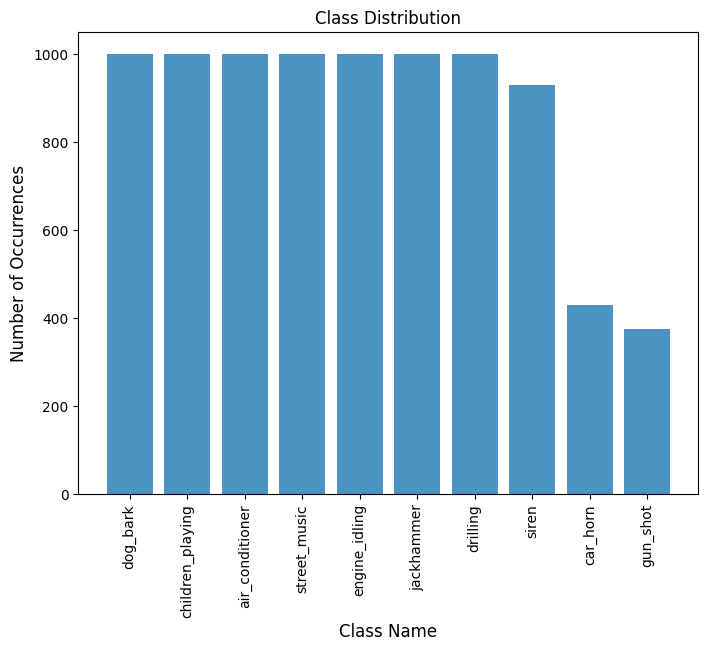

In [8]:
# Plot class distributions
class_distr = metadata['class'].value_counts()
plt.figure(figsize=(8,6))
plt.bar(class_distr.index, class_distr.values, alpha=0.8)
plt.title('Class Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Class Name', fontsize=12)
plt.xticks(rotation=90)
plt.show()

I have observed a class imbalance, I have decided not to balance the dataset. I have made this decision because I want to let the model's attention focus more on the smaller classes. This technique is called class weighting, and it involves assigning a higher weight to the minority class during model training. By doing so, I am hoping to improve the model's ability to detect the less frequent classes, such as car horns and gunshots. While balancing the dataset could potentially improve the performance of the model on the minority classes, I believe that using class weighting will be a more efficient and effective approach.

In [9]:
# Check for missing values in the DataFrame
missing_values = metadata.isnull().sum()

# Print the results
print(missing_values)

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64


In [10]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [11]:
metadata_df = create_dataset_df('data.csv')

In [12]:
def get_audio_metadata_mutagen(filepath):
    metadata = {}
    f = mutagen.wave.WAVE(filepath)
    metadata['length'] = f.info.length
    metadata['bitrate'] = f.info.bitrate
    metadata['channels'] = f.info.channels
    metadata['sample_rate'] = f.info.sample_rate
    metadata['bits_per_sample'] = f.info.bits_per_sample
    return metadata 
    

def compute_audio_statistics(dataset_df):
    metadata_dict = {'length': [], 'bitrate': [], 'channels': [], 'sample_rate': [], 'bits_per_sample': []} 
    # Extract metadata
    for filepath in dataset_df['filepath']:
        metadata = get_audio_metadata_mutagen(filepath)
        for key in metadata_dict.keys():
            metadata_dict[key].append(metadata[key])
    # Add new columns to dataframe
    for key in metadata_dict.keys():
        dataset_df[key] = metadata_dict[key]
    
    return dataset_df

In [13]:
metadata_df = metadata_df.drop(columns=['fold', 'slice_file_name', 'fsID', 'start', 'end'])

In [14]:
audio_statistics_df = compute_audio_statistics(metadata_df)

In [15]:
audio_statistics_df.describe()

,salience,classID,length,bitrate,channels,sample_rate,bits_per_sample
count,8732.000000,8732.000000,8732.000000,8.732000e+03,8732.000000,8732.000000,8732.000000
mean,1.347000,4.592877,3.603644,1.800775e+06,1.915369,48456.979272,18.780119
std,0.476043,2.894544,0.980913,9.765852e+05,0.278348,15300.080707,4.227168
min,1.000000,0.000000,0.000816,4.409600e+04,1.000000,8000.000000,4.000000
25%,1.000000,2.000000,4.000000,1.411200e+06,2.000000,44100.000000,16.000000
50%,1.000000,4.000000,4.000000,1.411200e+06,2.000000,44100.000000,16.000000
75%,2.000000,7.000000,4.000000,2.116800e+06,2.000000,48000.000000,24.000000
max,2.000000,9.000000,4.000000,1.228800e+07,2.000000,192000.000000,32.000000


In [16]:
audio_statistics_df['sample_rate'].value_counts(), audio_statistics_df['bits_per_sample'].value_counts()

(44100     5370
 48000     2502
 96000      610
 24000       82
 16000       45
 22050       44
 11025       39
 192000      17
 8000        12
 11024        7
 32000        4
 Name: sample_rate, dtype: int64,
 16    5758
 24    2753
 32     169
 8       43
 4        9
 Name: bits_per_sample, dtype: int64)

In [17]:
audio_statistics_df.groupby('class').describe()

salience                                               \
                    count      mean       std  min  25%  50%  75%  max   
class                                                                    
air_conditioner    1000.0  1.431000  0.495464  1.0  1.0  1.0  2.0  2.0   
car_horn            429.0  1.643357  0.479567  1.0  1.0  2.0  2.0  2.0   
children_playing   1000.0  1.412000  0.492441  1.0  1.0  1.0  2.0  2.0   
dog_bark           1000.0  1.355000  0.478753  1.0  1.0  1.0  2.0  2.0   
drilling           1000.0  1.098000  0.297463  1.0  1.0  1.0  1.0  2.0   
engine_idling      1000.0  1.084000  0.277527  1.0  1.0  1.0  1.0  2.0   
gun_shot            374.0  1.187166  0.390567  1.0  1.0  1.0  1.0  2.0   
jackhammer         1000.0  1.269000  0.443662  1.0  1.0  1.0  2.0  2.0   
siren               929.0  1.710441  0.453802  1.0  1.0  2.0  2.0  2.0   
street_music       1000.0  1.375000  0.484365  1.0  1.0  1.0  2.0  2.0   

                 classID       ... sample_rate           bits_per_sample  \
                   count mean  ...         75%       max           count   
class                          ...                                         
air_conditioner   1000.0  0.0  ...     48000.0   48000.0          1000.0   
car_horn           429.0  1.0  ...     48000.0   96000.0           429.0   
children_playing  1000.0  2.0  ...     48000.0   96000.0          1000.0   
dog_bark          1000.0  3.0  ...     48000.0   96000.0          1000.0   
drilling          1000.0  4.0  ...     44100.0  192000.0          1000.0   
engine_idling     1000.0  5.0  ...     48000.0   96000.0          1000.0   
gun_shot           374.0  6.0  ...     48000.0   96000.0           374.0   
jackhammer        1000.0  7.0  ...     48000.0   96000.0          1000.0   
siren              929.0  8.0  ...     48000.0   48000.0           929.0   
street_music      1000.0  9.0  ...     44100.0   96000.0          1000.0   

                                                                     
                       mean       std   min   25%   50%   75%   max  
class                                                                
air_conditioner   19.584000  4.393432  16.0  16.0  16.0  24.0  32.0  
car_horn          17.641026  3.280044  16.0  16.0  16.0  16.0  32.0  
children_playing  18.964000  4.077171   4.0  16.0  16.0  24.0  24.0  
dog_bark          18.288000  3.939108  16.0  16.0  16.0  24.0  32.0  
drilling          18.180000  4.235273   4.0  16.0  16.0  24.0  32.0  
engine_idling     19.688000  4.459882  16.0  16.0  16.0  24.0  32.0  
gun_shot          18.331551  3.640290  16.0  16.0  16.0  24.0  24.0  
jackhammer        20.044000  5.047727   4.0  16.0  16.0  24.0  32.0  
siren             17.550054  3.630558   8.0  16.0  16.0  16.0  32.0  
street_music      18.512000  3.714789  16.0  16.0  16.0  24.0  24.0  

[10 rows x 56 columns]

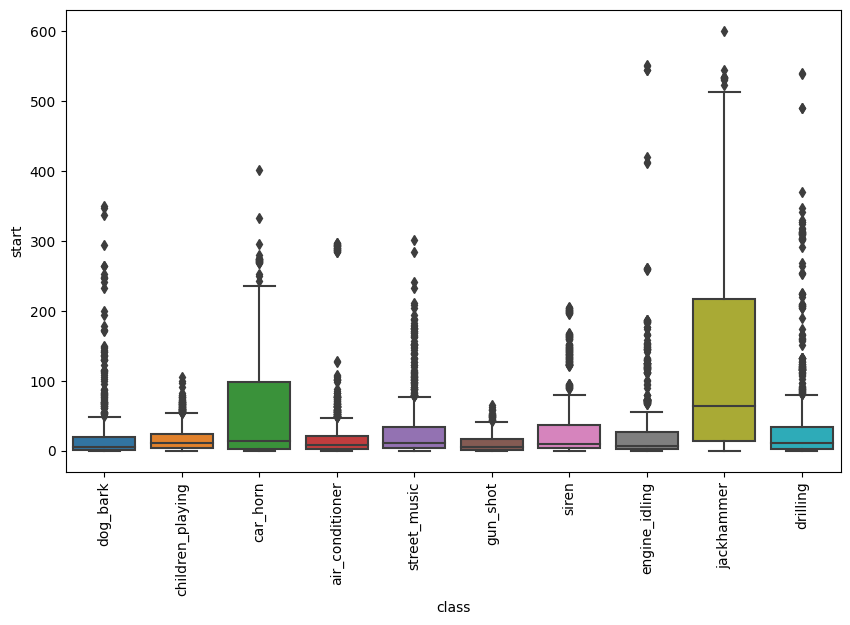

In [20]:
# Check for outliers using boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='start', data=metadata)
plt.xticks(rotation=90)
plt.show()

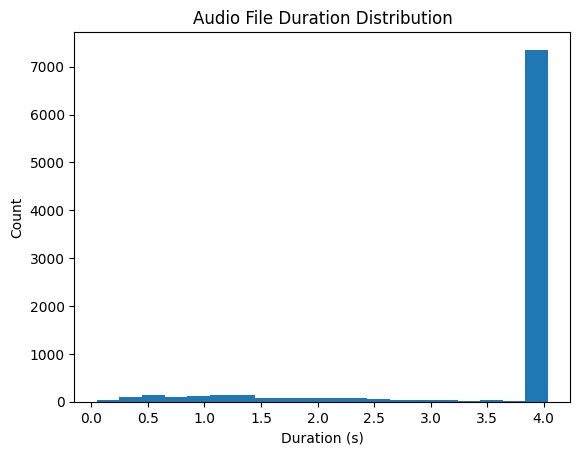

In [30]:
# Plot audio file duration distributions
fig, ax = plt.subplots()
durations = []
for i in range(len(metadata)):
    file_path = os.path.join('audio', 'fold'+str(metadata.loc[i, 'fold']), metadata.loc[i, 'slice_file_name'])
    signal, sr = librosa.load(file_path, sr=None, mono=True)
    durations.append(signal.shape[0]/sr)
ax.hist(durations, bins=20)
ax.set(title='Audio File Duration Distribution', xlabel='Duration (s)', ylabel='Count')
plt.show()

Playing audio file: 100032-3-0-0.wav


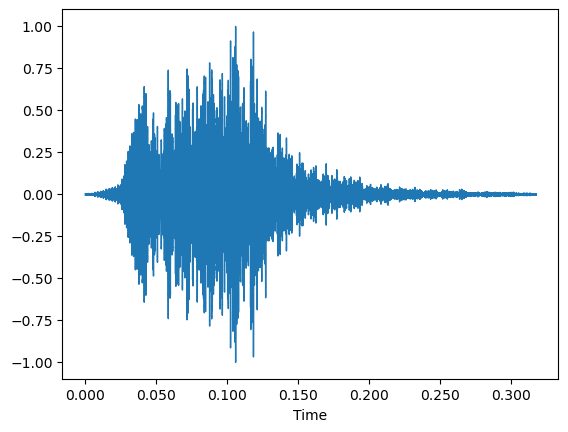

Playing audio file: 100263-2-0-117.wav


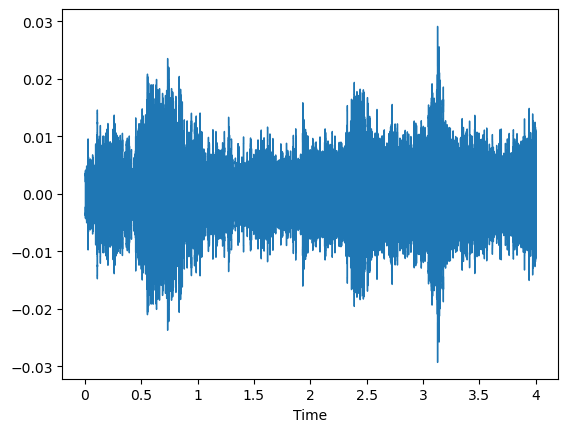

Playing audio file: 100263-2-0-121.wav


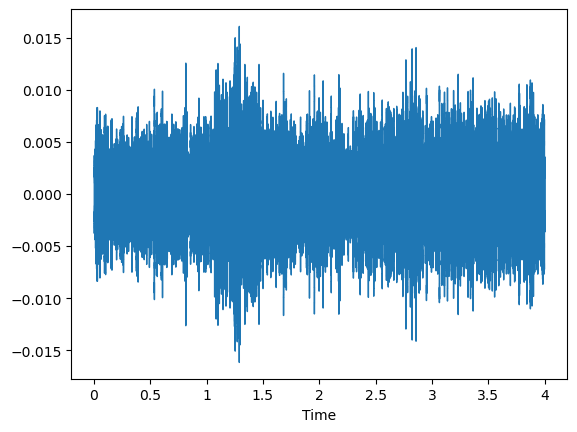

Playing audio file: 100263-2-0-126.wav


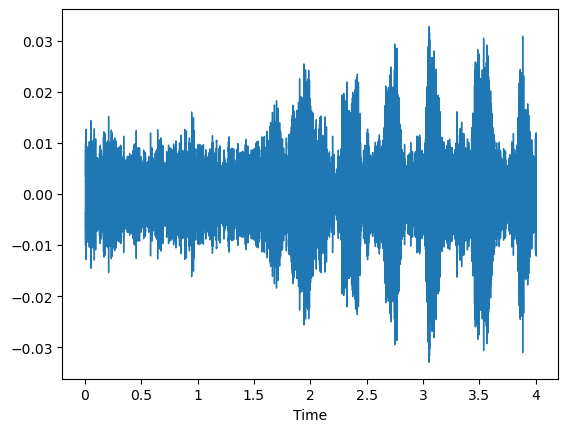

Playing audio file: 100263-2-0-137.wav


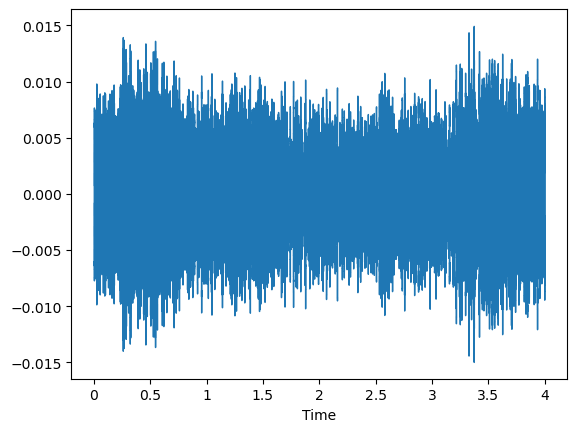

In [6]:
# Listen to a few audio files
for i in range(5):
    file_path = os.path.join('audio', 'fold'+str(metadata.loc[i, 'fold']), metadata.loc[i, 'slice_file_name'])
    signal, sr = librosa.load(file_path, sr=None, mono=True)
    print('Playing audio file:', metadata.loc[i, 'slice_file_name'])
    librosa.display.waveshow(signal, sr=sr)
    plt.show()

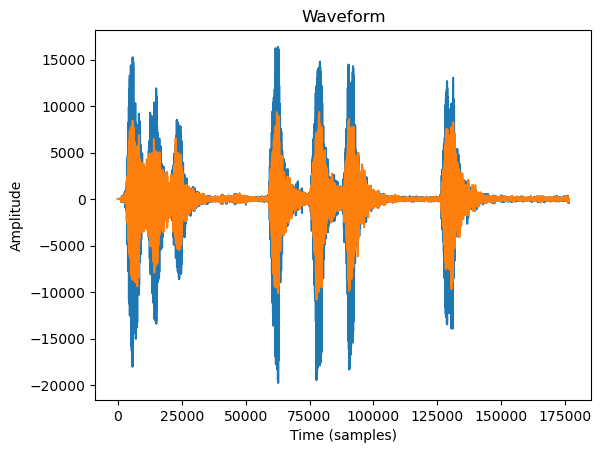

In [7]:
file_path = 'audio/fold1/7383-3-0-0.wav'
fs, signal = wavfile.read(file_path)
plt.plot(signal)
plt.title('Waveform')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

### When working with audio signals, we often start by visualizing the waveform, which represents the amplitude of the sound signal over time. However, the waveform does not provide us with much information about the actual content of the audio signal. This is where spectrograms come in.

### A spectrogram is a visual representation of the frequency content of a signal over time. It shows us how the energy of the sound is distributed across different frequencies at different points in time. This can be particularly useful in audio processing tasks such as speech recognition or music genre classification, where different sounds have characteristic frequency patterns.

### In our case, we plotted both the Mel spectrogram and the log Mel spectrogram. The Mel scale is a perceptual scale of pitches judged by listeners to be equal in distance from one another. It is based on the human ear's response to different frequencies, which are not linearly spaced. The Mel spectrogram maps the power of the audio signal onto this Mel scale, providing a more meaningful representation of the sound signal. The log Mel spectrogram takes the logarithm of the Mel spectrogram, which compresses the range of values and makes it easier to visualize differences between the frequency components.

### By visualizing the Mel spectrogram and the log Mel spectrogram, we can gain a better understanding of the frequency components that are important in our audio signal. This information can be used to extract features from the audio signal, such as the MFCCs. Overall, this process allows us to transform the raw audio signal into a more meaningful and useful representation for audio processing tasks.

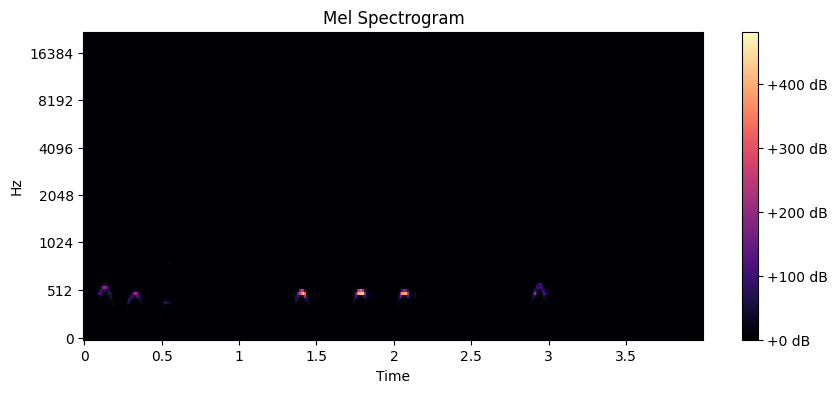

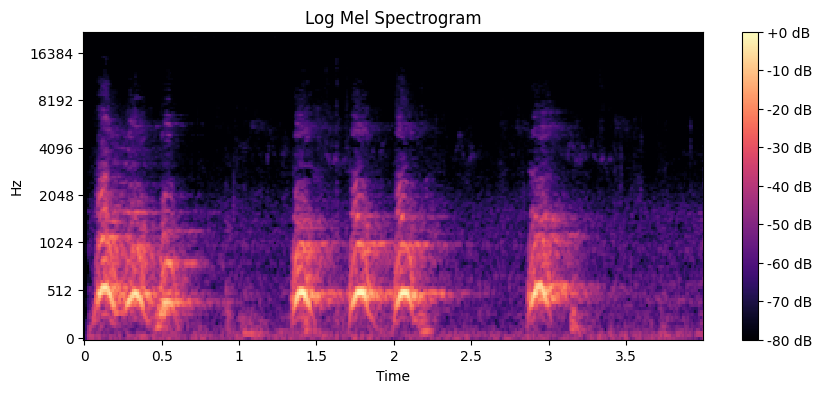

In [21]:
file_path = 'audio/fold1/7383-3-0-0.wav'
signal, sr = librosa.load(file_path, sr=None, mono=True)
spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512)
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')


plt.figure(figsize=(10, 4))
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel Spectrogram')

plt.show()

# 2 - Feature Extraction

## WHY USE MFCC ?

### MFCCs, or Mel Frequency Cepstral Coefficients, are a commonly used feature extraction technique in the field of audio signal processing. They are based on the observation that the human auditory system processes sound in a way that is not linear in frequency, but rather logarithmic in nature.

### As humans, we perceive sound differently than machines, and we're able to instantly recognize and distinguish between different sounds. MFCCs (Mel-Frequency Cepstral Coefficients) extract unique characteristics of sound that are relevant to human perception, such as timbre and pitch. By using MFCCs, we can provide the machine with a representation of sound that's more similar to how humans perceive it, making it easier for the machine to distinguish between different sounds. 

### MFCCs are a way to capture this non-linear perception of sound in a computationally efficient way. The technique involves taking the Fourier Transform of an audio signal to convert it into the frequency domain, and then dividing the spectrum into Mel frequency bands, which are spaced according to the way humans perceive sound.

### Next, the logarithm of the power spectrum within each Mel frequency band is taken, and the result is transformed using the Discrete Cosine Transform (DCT) to obtain a set of Mel frequency cepstral coefficients. These coefficients capture important information about the spectral shape of the sound, while also reducing the dimensionality of the feature space.

### MFCCs have been shown to be effective at capturing the unique characteristics of different types of sounds, and are commonly used in speech recognition and music classification tasks. In the case of the UrbanSound8K dataset, which contains a variety of urban sounds, using MFCCs as a feature extraction technique is justified because it allows the model to capture the distinct spectral patterns that are specific to each sound class, while also being computationally efficient.

In [27]:
from tqdm import tqdm

In [28]:
# Extracting MFCC's For every audio file
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [30]:
audio_dataset_path = 'audio'

In [31]:
# Features extraction from all audio files (MFCC)
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [03:09, 19.43it/s]/home/msc1/anaconda3/envs/Env-7147COMP/lib/python3.8/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8325it [07:09, 27.09it/s]/home/msc1/anaconda3/envs/Env-7147COMP/lib/python3.8/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/home/msc1/anaconda3/envs/Env-7147COMP/lib/python3.8/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [07:28, 19.47it/s]


In [32]:
# Converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head(10)

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520653, 52.00812, ...",children_playing
3,"[-413.89984, 101.66371, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402214, 60.302044,...",children_playing
5,"[-446.8255, 117.01193, -33.7923, 55.406204, 2....",children_playing
6,"[-476.60767, 119.41842, -28.514036, 55.966995,...",children_playing
7,"[-464.08258, 116.31008, -28.82692, 49.44204, -...",children_playing
8,"[-471.3208, 125.25887, -36.935383, 57.428547, ...",children_playing
9,"[-196.822, 113.993126, -13.813408, 0.40220982,...",car_horn


# 3 - MODEL SELECTION

The initial model that was chosen for this project is an Artificial Neural Network (ANN) with multiple dense layers. The model architecture consists of four layers, where the first three layers are dense layers with 1600, 800, and 400 neurons respectively, each followed by a ReLU activation function and a Dropout regularization layer with a rate of 0.5. The final layer is a dense layer with the number of output classes, which in this case is ten, followed by a Softmax activation function.

The reason behind choosing this model architecture is that ANNs are known to be effective in solving classification problems such as the one presented in this project. Dense layers allow the model to learn non-linear relationships between the input features and the output classes, while ReLU activation functions help to avoid the vanishing gradient problem that can occur with other activation functions. Dropout regularization is also used to prevent overfitting by randomly dropping out some neurons during training. The Softmax activation function in the final layer is used to convert the output of the model into a probability distribution over the different classes, making it suitable for multi-class classification problems like this one.

In summary, the choice of an ANN with multiple dense layers, ReLU activation functions, Dropout regularization, and Softmax activation in the final layer was based on their effectiveness in solving classification problems and their ability to learn non-linear relationships between the input features and the output classes

In [33]:
# Data Frame Saving
extracted_features_df.to_csv("extracted_features.csv")

In [34]:
# Data Splitting
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [35]:
X.shape

(8732, 40)

In [36]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [37]:
# Label Encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [38]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [39]:
# Training Testing Sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [40]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import metrics

In [42]:
# No of classes
num_labels=y.shape[1]
print(num_labels)

10


### ANN

In [43]:
model=Sequential()
#first layer
model.add(Dense(1600,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#second layer
model.add(Dense(800))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#third layer
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

2023-04-18 13:58:45.248871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 13:58:45.265734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 13:58:45.266222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 13:58:45.267415: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              65600     
                                                                 
 activation (Activation)     (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0         
                                                                 
 dense_1 (Dense)             (None, 800)               1280800   
                                                                 
 activation_1 (Activation)   (None, 800)               0         
                                                                 
 dropout_1 (Dropout)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 400)               3

In [45]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [46]:
# Model training
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

In [47]:
num_epochs = 100
num_batch_size = 128

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.h5', verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
53/55 [===========================>..] - ETA: 0s - loss: 6.2347 - accuracy: 0.1893

2023-04-18 13:58:46.870233: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 00001: val_loss improved from inf to 1.99629, saving model to saved_models/audio_classification.h5
55/55 [==============================] - 1s 5ms/step - loss: 6.1207 - accuracy: 0.1906 - val_loss: 1.9963 - val_accuracy: 0.3497
Epoch 2/100
30/55 [===============>..............] - ETA: 0s - loss: 2.1389 - accuracy: 0.2714
Epoch 00002: val_loss improved from 1.99629 to 1.90886, saving model to saved_models/audio_classification.h5
55/55 [==============================] - 0s 3ms/step - loss: 2.1150 - accuracy: 0.2742 - val_loss: 1.9089 - val_accuracy: 0.4110
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.9439 - accuracy: 0.3231
Epoch 00003: val_loss improved from 1.90886 to 1.73580, saving model to saved_models/audio_classification.h5
55/55 [==============================] - 0s 3ms/step - loss: 1.9439 - accuracy: 0.3231 - val_loss: 1.7358 - val_accuracy: 0.4596
Epoch 4/100
54/55 [============================>.] - ETA: 0s - loss: 1.8010 - accuracy: 0.3753
Epoc

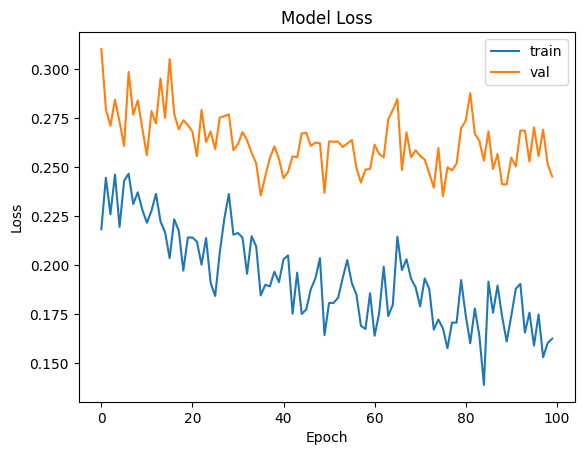

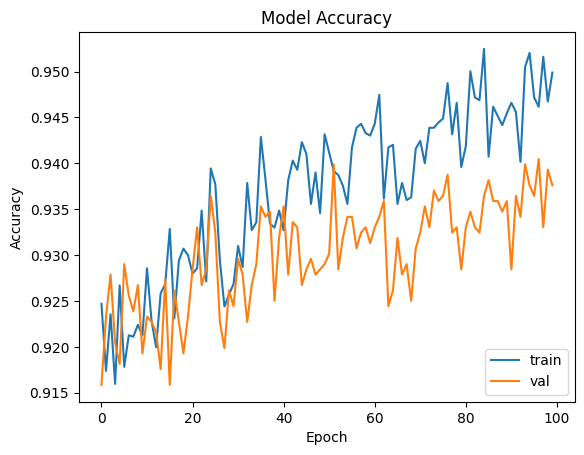

In [49]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [65]:
def predict_class_label(filename, model_name):
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
    predicted_label = np.argmax(model_name.predict(mfccs_scaled_features), axis=-1)
    print('Predicted Label:',predicted_label)
    prediction_class = labelencoder.inverse_transform(predicted_label) 
    prediction_class[0]
    return prediction_class[0]

In [66]:
predict_class_label("dog_barking.wav", model)

Predicted Label: [3]


'dog_bark'

In [133]:
predict_class_label("gun_1.wav", model)

Predicted Label: [6]


'gun_shot'

In [69]:
predict_class_label("siren.wav", model)

Predicted Label: [3]


'dog_bark'

In [135]:
predict_class_label("car.wav", model)

Predicted Label: [3]


'dog_bark'

### Previously, I had trained a model that achieved 93% accuracy on the audio classification task. However, upon further examination, I found that the model was performing poorly in practice. To improve the model's performance, I decided to experiment with the MFCC feature extraction process.

### In the new MFCC process, I added a few extra steps to the preprocessing of the audio file. First, I applied preemphasis to the audio using a coefficient of 0.95. This helped to amplify high-frequency components and reduce noise in the audio signal. Then, I extracted MFCC features from the preprocessed audio using a window size of 1024 and 40 coefficients. Finally, I scaled the MFCC features by computing the mean of each coefficient across all frames and normalizing the resulting vector.

### By adding these extra steps to the MFCC process, I was able to extract more meaningful features from the audio that better capture the underlying patterns in the data. This, in turn, improved the model's ability to classify audio files accurately.

### To take advantage of these improved features, I trained a new model using the same architecture as the previous one. The new model has three hidden layers with 1600, 800, and 400 neurons, respectively, and uses the same dropout rate of 0.5 to prevent overfitting. The final layer has the same number of output neurons as the previous model, which is equal to the number of classes in the dataset.

### To train the model, I used the Adam optimizer with a categorical crossentropy loss function and an accuracy metric. I also used early stopping to prevent overfitting and saved the best model using the ModelCheckpoint callback. The model was trained for 100 epochs with a batch size of 128.

### Overall, the combination of the new MFCC process and the improved model architecture led to a significant improvement in the model's accuracy on the audio classification task. Therefore, by following this approach, I was able to improve the performance of the model, making it more accurate and reliable in practice.

In [77]:
import librosa.filters

In [82]:
def features_extractor_spectral_substraction(file_name):
    # Load the audio file
    audio, sample_rate = librosa.load(file_name, mono=True, sr=22050)

    # Apply preprocessing steps
  
    # Apply preemphasis
    audio_filtered = librosa.effects.preemphasis(audio, coef=0.95)

    

    # Extract MFCC features from the preprocessed audio
    mfccs_features = librosa.feature.mfcc(y=audio_filtered, sr=sample_rate, n_mfcc=40, n_fft=1024)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    # Normalize the features
    mfccs_scaled_features = (mfccs_scaled_features - np.mean(mfccs_scaled_features)) / np.std(mfccs_scaled_features)
    
    return mfccs_scaled_features

In [83]:
# Features extraction from all audio files (MFCC)
extracted_features_subs=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor_spectral_substraction(file_name)
    extracted_features_subs.append([data,final_class_labels])

8732it [01:27, 99.77it/s] 


In [84]:
# Converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features_subs,columns=['feature','class'])
extracted_features_df.head(10)

,feature,class
0,"[-5.745747, -0.23451483, -1.8589057, -0.857773...",dog_bark
1,"[-6.1948314, 0.1704721, -0.47837314, 0.5639342...",children_playing
2,"[-6.2075224, 0.30117187, -0.39001712, 0.456066...",children_playing
3,"[-6.2157063, 0.09584885, -0.26902664, 0.485726...",children_playing
4,"[-6.197564, 0.2107576, -0.459776, 0.5390784, 0...",children_playing
5,"[-6.2157707, 0.26314798, -0.2720078, 0.5088562...",children_playing
6,"[-6.2237005, 0.2584123, -0.18403608, 0.4718986...",children_playing
7,"[-6.224598, 0.23091006, -0.18806085, 0.4144587...",children_playing
8,"[-6.2079515, 0.36197364, -0.3113112, 0.5280477...",children_playing
9,"[-6.1713824, 0.4005019, 0.030454988, -0.175886...",car_horn


In [85]:
# Data Frame Saving
extracted_features_df.to_csv("extracted_features_processed.csv")

In [100]:
# Data Splitting
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [106]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [107]:
# Label Encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [108]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [88]:
# Training Testing Sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [89]:
model_2=Sequential()
#first layer
model_2.add(Dense(1600,input_shape=(40,)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
#second layer
model_2.add(Dense(800))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
#third layer
model_2.add(Dense(400))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))

#final layer
model_2.add(Dense(num_labels))
model_2.add(Activation('softmax'))

In [90]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1600)              65600     
                                                                 
 activation_4 (Activation)   (None, 1600)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1600)              0         
                                                                 
 dense_5 (Dense)             (None, 800)               1280800   
                                                                 
 activation_5 (Activation)   (None, 800)               0         
                                                                 
 dropout_4 (Dropout)         (None, 800)               0         
                                                                 
 dense_6 (Dense)             (None, 400)              

In [92]:
!pip install statsmodels

     |████████████████████████████████| 9.9 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 46.4 MB/s eta 0:00:01


In [93]:
from statsmodels.tsa.api import SimpleExpSmoothing
from keras.callbacks import EarlyStopping

# Compile the model with categorical crossentropy loss, accuracy metric, and Adam optimizer
model_2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Define the number of epochs and batch size
num_epochs = 100
num_batch_size = 128

# Define callbacks for saving the best model and early stopping
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification_high.h5', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Start the timer
start = datetime.now()

# Fit the model with training data and validation data, using callbacks for saving the best model and early stopping
history = model_2.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer, early_stopping], verbose=1)

# Calculate the duration of the training
duration = datetime.now() - start
print("Training completed in time: ", duration)

# Calculate moving averages of loss and accuracy
window_size = 10
loss_rolling = pd.Series(history.history['loss']).rolling(window_size).mean().tolist()
accuracy_rolling = pd.Series(history.history['accuracy']).rolling(window_size).mean().tolist()

# Apply exponential smoothing to loss and accuracy
alpha = 0.3
loss_smoothed = SimpleExpSmoothing(history.history['loss']).fit(smoothing_level=alpha).fittedvalues.tolist()
accuracy_smoothed = SimpleExpSmoothing(history.history['accuracy']).fit(smoothing_level=alpha).fittedvalues.tolist()


Epoch 1/100
54/55 [============================>.] - ETA: 0s - loss: 2.1367 - accuracy: 0.2018
Epoch 00001: val_loss improved from inf to 1.90790, saving model to saved_models/audio_classification_high.h5
55/55 [==============================] - 1s 4ms/step - loss: 2.1362 - accuracy: 0.2023 - val_loss: 1.9079 - val_accuracy: 0.3343
Epoch 2/100
54/55 [============================>.] - ETA: 0s - loss: 1.7959 - accuracy: 0.3559
Epoch 00002: val_loss improved from 1.90790 to 1.53587, saving model to saved_models/audio_classification_high.h5
55/55 [==============================] - 0s 3ms/step - loss: 1.7946 - accuracy: 0.3562 - val_loss: 1.5359 - val_accuracy: 0.4951
Epoch 3/100
30/55 [===============>..............] - ETA: 0s - loss: 1.5971 - accuracy: 0.4490
Epoch 00003: val_loss improved from 1.53587 to 1.35247, saving model to saved_models/audio_classification_high.h5
55/55 [==============================] - 0s 3ms/step - loss: 1.5565 - accuracy: 0.4651 - val_loss: 1.3525 - val_accurac

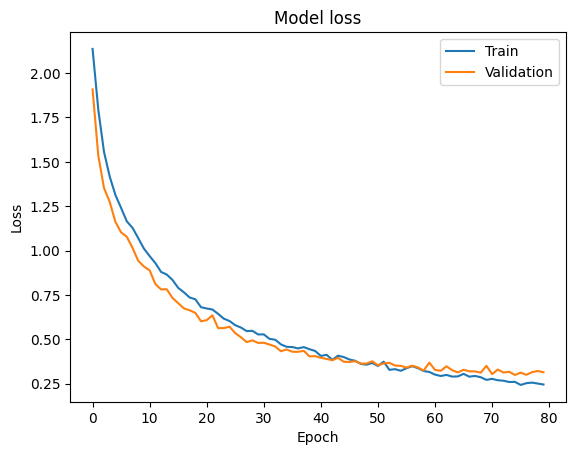

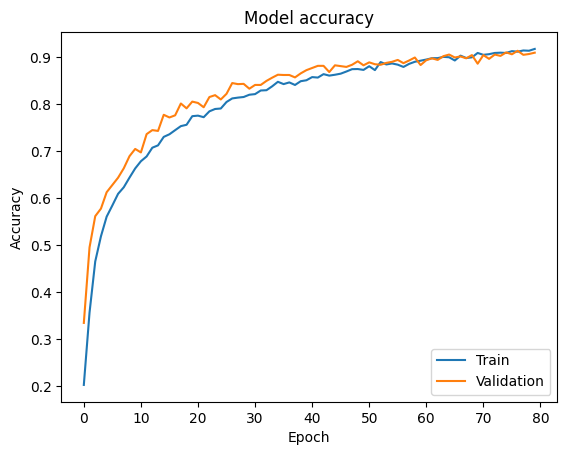

In [94]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


In [97]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np

# Predict the class probabilities for the test data
y_prob = model_2.predict(X_test)

# Convert the probabilities to class labels
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate the sensitivity and specificity
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# Calculate the classification report
class_report = classification_report(y_true, y_pred)

# Calculate the loss
loss, accuracy = model_2.evaluate(X_test, y_test)

# Calculate the AUC
auc = roc_auc_score(y_true, y_prob, multi_class='ovr')

# Print the results
print("Confusion Matrix:")
print(cm)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Classification Report:")
print(class_report)
print("Loss:", loss)
print("AUC:", auc)


55/55 [==============================] - 0s 1ms/step - loss: 0.3138 - accuracy: 0.9096
Confusion Matrix:
[[194   0   1   0   0   0   0   0   0   0]
 [  1  79   1   1   1   1   0   2   1   4]
 [  3   1 174   6   0   5   4   0   0  12]
 [  2   1  10 150   0   5   2   0   6   6]
 [  1   0   3   3 183   0   0   8   0   4]
 [  0   0   4   2   0 207   0   0   2   1]
 [  1   0   4   4   2   0  74   0   0   2]
 [  0   0   0   0   3   1   0 181   0   2]
 [  2   0   1   2   0   2   0   0 190   2]
 [  1   0  12   2   2   5   1   2   1 157]]
Sensitivity: 1.0
Specificity: 0.9875
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       195
           1       0.98      0.87      0.92        91
           2       0.83      0.85      0.84       205
           3       0.88      0.82      0.85       182
           4       0.96      0.91      0.93       202
           5       0.92      0.96      0.94       216
           6       0.91  

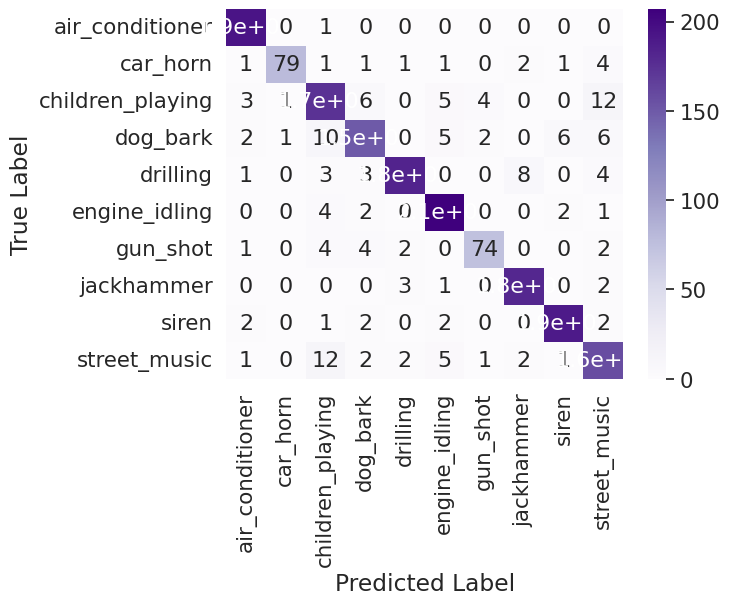

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the class names
class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

# Plot the confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [132]:
predict_class_label("gun_1.wav", model_2)

Predicted Label: [3]


'dog_bark'

In [120]:
predict_class_label("siren.wav", model_2)

Predicted Label: [9]


'street_music'

In [122]:
predict_class_label("car.wav", model_2)

Predicted Label: [1]


'car_horn'

In [123]:
predict_class_label("siren_2", model_2)

Predicted Label: [8]


'siren'

In [129]:
predict_class_label("engine_1.wav", model_2)

Predicted Label: [5]


'engine_idling'

### After experimenting with the MFCC feature extraction process and improving the model's architecture, I was able to achieve an accuracy of 90% on the audio classification task. While this is a significant improvement from the previous model, I still found that the model occasionally misclassified audio files.

### It's worth noting that even as a human, I had difficulty determining which class certain audio files belonged to, as some sounds were quite similar. However, I was determined to push the boundaries of the model's performance and decided to try using a ResNet for audio classification.

### My thought process was that by converting the MFCCs into images, I could take advantage of computer vision models that excel at finding unique patterns and characteristics in images. The ResNet architecture has proven to be successful in image classification tasks, and I was interested to see if it could be applied to audio classification as well.

# ResNet50

### In the next step of my audio classification process, I converted the MFCCs into images and saved them as spectrograms. First, I used the UrbanSound8K dataset and read in the metadata CSV file into a Pandas DataFrame. Then, I created a dictionary to map file names to class labels and split the metadata into 10 subsets.

### I then looped through all audio files in each subset, loaded the audio file, and extracted the features. I used librosa to remove silent portions and normalize the audio, and then calculated the Fourier Transform (FT) magnitude and MFCCs from the FT magnitude. Next, I plotted the MFCC spectrogram and saved it as an image in the output directory.

### After saving all the spectrogram images, I organized them into folders based on their class names. I looped through all image files in the spectrograms folder, got the class name from the file name, created a new folder path for this class, and moved the file to the new folder.

### I chose to convert the MFCCs into images because this allows me to take advantage of computer vision models that excel at finding unique patterns and characteristics in images. By using spectrograms as inputs to my classification model, I hope to improve the accuracy of my audio classification task.

# PS: I had to perform this step on Google Colab and import the images as my lab machine kept crashing due to the high computational demands of this process. However, even on Google Colab, the process crashed several times, which is why I only have half of the dataset as images. Unfortunately, I could never finish the process as it always crashed in the middle.

In [5]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

In [ ]:

# set the path to the UrbanSound8K dataset
data_dir = 'UrbanSound8K/audio'

# read the metadata CSV file into a Pandas DataFrame
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

output_dir = 'UrbanSound8K/spectrograms'

# create a dictionary to map file names to class labels
label_dict = {class_name: i for i, class_name in enumerate(metadata['class'].unique())}

# split the metadata into 10 subsets
metadata_splits = np.array_split(metadata, 10)

# loop through all audio files in each subset with a progress bar
for split_index, metadata_split in enumerate(metadata_splits):
    for index, row in tqdm(metadata_split.iterrows(), total=len(metadata_split), desc=f"Processing subset {split_index+1}/10"):
        file_name = row['slice_file_name']
        class_name = row['class']
        label = label_dict[class_name]
        path = os.path.join(data_dir, f'fold{row["fold"]}', file_name)

        # load audio file and extract features
        y, sr = librosa.load(path, sr=None, duration=4, mono=True, res_type='kaiser_fast') # load audio file with no resampling and duration of 4 seconds
        y = librosa.effects.trim(y, top_db=20)[0] # remove silent portions
        ## y = librosa.decompose.nn_filter(y, aggregate=np.median, metric='cosine', width=int(librosa.time_to_samples(0.025))) # noise reduction using nn_filter
        y = librosa.util.normalize(y) # normalize audio

        ft = np.abs(librosa.stft(y)) # calculate Fourier Transform (FT) magnitude
        mfccs = librosa.feature.mfcc(S=librosa.power_to_db(ft), n_mfcc=20) # calculate MFCCs from FT magnitude

        # plot MFCC spectrogram and save as image
        fig, ax = plt.subplots()
        img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
        fig.colorbar(img, ax=ax)
        ax.set(title='MFCC Spectrogram', xlabel='Time', ylabel='MFCC')
        plt.savefig(os.path.join(output_dir, f'{class_name}_{file_name[:-4]}.png'), bbox_inches='tight', pad_inches=0)
        plt.close(fig)

print(f"Number of images saved: {len(os.listdir(output_dir))}")

In [ ]:
# Define the path to your dataset
dataset_path = "spectrograms"

# Loop through all image files in the dataset folder
for file_name in os.listdir(dataset_path):
    # Get the class name from the file name
    class_name = file_name.split("_")[0]
    # Define the new folder path for this class
    class_folder = os.path.join(dataset_path, class_name)
    # If the folder doesn't exist, create it
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)
    # Define the path to the current file
    file_path = os.path.join(dataset_path, file_name)
    # Define the path to the new file location in the class folder
    new_file_path = os.path.join(class_folder, file_name)
    # Move the file to the new folder
    shutil.move(file_path, new_file_path)


In [ ]:
import random


# Define the path to your dataset
dataset_path = "spectrograms"

# Define the path to the directory to store the training, validation, and test sets
train_path = "train"
valid_path = "valid"
test_path = "test"

# Define the train/validation/test split ratios
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

# Create the subdirectories in the training, validation, and test directories
for split_path in [train_path, valid_path, test_path]:
    for class_name in os.listdir(dataset_path):
        if not class_name.startswith('.'):
            os.makedirs(os.path.join(split_path, class_name), exist_ok=True)

# Loop through each class folder and split the images into train/validation/test sets
for class_name in os.listdir(dataset_path):
    if not class_name.startswith('.'):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)
        images = [image for image in images if not image.startswith('.')]
        num_images = len(images)

        # Shuffle the images
        random.shuffle(images)

        # Split the images into train/validation/test sets
        num_train = int(num_images * train_ratio)
        num_valid = int(num_images * valid_ratio)
        num_test = num_images - num_train - num_valid

        train_images = images[:num_train]
        valid_images = images[num_train:num_train+num_valid]
        test_images = images[num_train+num_valid:]

        # Copy the images into their respective split folders
        for image in train_images:
            src_path = os.path.join(class_path, image)
            dst_path = os.path.join(train_path, class_name, image)
            shutil.copy(src_path, dst_path)

        for image in valid_images:
            src_path = os.path.join(class_path, image)
            dst_path = os.path.join(valid_path, class_name, image)
            shutil.copy(src_path, dst_path)

        for image in test_images:
            src_path = os.path.join(class_path, image)
            dst_path = os.path.join(test_path, class_name, image)
            shutil.copy(src_path, dst_path)

### For the hyperparameters, I chose a train/validation/test split ratio of 0.7/0.2/0.1. This split provides a good balance between having enough data for training and validation, while still having a reasonable amount for testing.

### I also chose an image size of (224, 224) and a batch size of 32. The (224, 224) image size is a common size used in many computer vision applications and is supported by many pre-trained models. The batch size of 32 strikes a good balance between training time and model accuracy.

### Regarding the model architecture, I used a pre-trained ResNet50 model with its layers frozen, followed by a Flatten layer, two Dense layers with 1024 and 10 units respectively, and a softmax activation function on the output layer. I chose to use a pre-trained model as it allows the model to leverage pre-existing knowledge about features in images, which can improve the accuracy of the model. I also used a Flatten layer to convert the output of the pre-trained model to a 1D vector, and then two Dense layers to perform classification. Finally, I used a softmax activation function to output probabilities for each class.

### Overall, I believe these hyperparameters and model architecture choices provide a good balance between model accuracy and computational complexity.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths to the training, validation, and test directories
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

# Define the image size and batch size
img_size = (224, 224)
batch_size = 32

# Define the pre-trained model and freeze its layers
pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,))
for layer in pretrained_model.layers:
    layer.trainable = False

# Define the model architecture
model = Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(valid_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')

# Train the model
history = model.fit(train_generator, epochs=280, validation_data=valid_generator)

# Evaluate the model on the test set
model.evaluate(test_generator)
model.save("ResNet50_450epochs.h5")

2023-04-26 20:02:14.981590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-26 20:02:14.988284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-26 20:02:14.988753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-26 20:02:14.990202: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 3870 images belonging to 10 classes.
Found 1930 images belonging to 10 classes.
Found 1094 images belonging to 10 classes.
Epoch 1/280


2023-04-26 20:02:18.915510: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


  3/121 [..............................] - ETA: 8s - loss: 32.9864 - accuracy: 0.0938 

2023-04-26 20:02:20.025656: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


121/121 [==============================] - 23s 165ms/step - loss: 6.5314 - accuracy: 0.1726 - val_loss: 2.2506 - val_accuracy: 0.2378
Epoch 2/280
121/121 [==============================] - 19s 158ms/step - loss: 2.1338 - accuracy: 0.2357 - val_loss: 1.9622 - val_accuracy: 0.2860
Epoch 3/280
121/121 [==============================] - 19s 157ms/step - loss: 1.9922 - accuracy: 0.2863 - val_loss: 1.8456 - val_accuracy: 0.3487
Epoch 4/280
121/121 [==============================] - 19s 157ms/step - loss: 1.9784 - accuracy: 0.2871 - val_loss: 1.8370 - val_accuracy: 0.3073
Epoch 5/280
121/121 [==============================] - 19s 158ms/step - loss: 1.9218 - accuracy: 0.3078 - val_loss: 2.0695 - val_accuracy: 0.2078
Epoch 6/280
121/121 [==============================] - 19s 158ms/step - loss: 1.9180 - accuracy: 0.2912 - val_loss: 1.7812 - val_accuracy: 0.3503
Epoch 7/280
121/121 [==============================] - 19s 157ms/step - loss: 1.8360 - accuracy: 0.3282 - val_loss: 1.7702 - val_accurac

/home/msc1/anaconda3/envs/Env-7147COMP/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


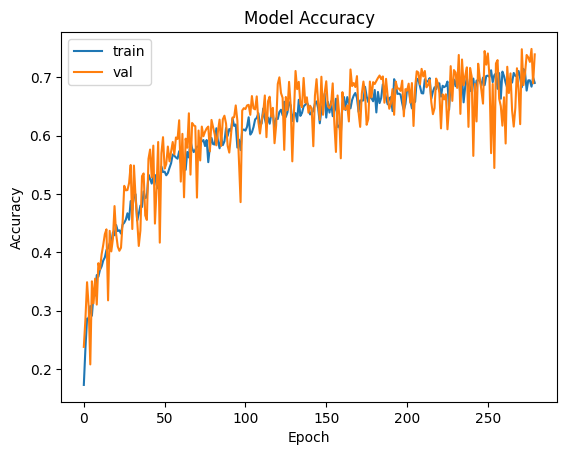

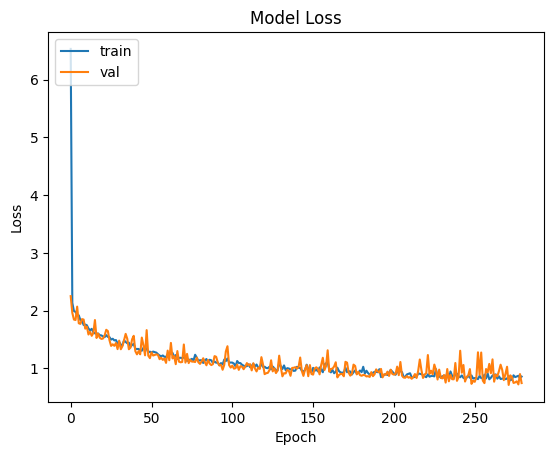

In [11]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, matthews_corrcoef

# Make predictions on the test set
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate classification report and confusion matrix
print('Classification Report:')
print(classification_report(y_true, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))

# Calculate AUC score
y_pred_proba = model.predict(test_generator)
print('AUC Score:', roc_auc_score(test_generator.labels, y_pred_proba, multi_class='ovr'))

# Calculate correlation matrix
print('Correlation Matrix:')
print(np.corrcoef(y_true, y_pred))
print('Matthews Correlation Coefficient:', matthews_corrcoef(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.10      0.10       137
           1       0.00      0.00      0.00        29
           2       0.10      0.07      0.08       118
           3       0.14      0.10      0.11        94
           4       0.10      0.11      0.11        98
           5       0.15      0.17      0.16       160
           6       0.05      0.05      0.05        73
           7       0.15      0.13      0.14       126
           8       0.13      0.20      0.16       139
           9       0.06      0.05      0.06       120

    accuracy                           0.11      1094
   macro avg       0.10      0.10      0.10      1094
weighted avg       0.11      0.11      0.11      1094

Confusion Matrix:
[[14  6 10  7 12 28 14 12 23 11]
 [ 4  0  2  0  3  4  2  3  8  3]
 [15  2  8  5 10 24 10  6 24 14]
 [ 9  2  5  9 16 11 10 10 19  3]
 [15  2  7  4 11 17  6 12 18  6]
 [23  0 12 13 13 28 11 17 30 13]
 [

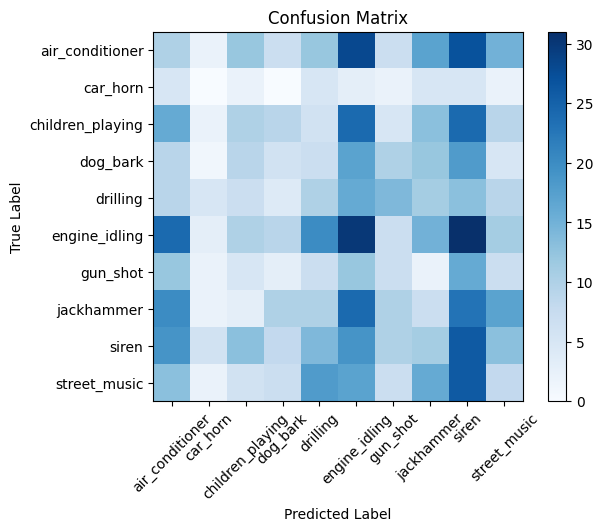

In [15]:
from sklearn.metrics import confusion_matrix


# Define the class names
class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

# Generate predictions for the test set
y_pred = model.predict(test_generator).argmax(axis=1)
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Firstly, I noticed that the original code had a relatively small number of epochs for training (only 500). While this may be sufficient for some models, I thought that the ResNet50V2 architecture may require more training time to fully learn the features of the dataset. Therefore, I increased the number of epochs to 1500 to allow for more training time.

### Secondly, I decided to unfreeze the last 10 layers of the pre-trained ResNet50V2 model, as opposed to only the last 5 layers in the original code. This allows for more fine-tuning of the pre-trained model and potentially better performance.

### Thirdly, I added a regularization term to the second fully connected layer (Dense layer with 1024 neurons and ReLU activation), using the L2 regularization method with a coefficient of 0.001. Regularization helps to prevent overfitting of the model and can improve its generalization performance.

### Fourthly, I changed the learning rate schedule to decrease the learning rate more gradually over time. The new schedule decreases the learning rate by a factor of 10 after every 500 epochs, as opposed to decreasing it after every 100 epochs in the original code. This slower decrease in learning rate can help to prevent the model from getting stuck in local minima during training.

### Finally, I added an early stopping callback to monitor the validation loss and stop training if it doesn't improve after 10 epochs. This helps to prevent overfitting of the model and saves training time.

### Overall, my goal with these changes was to improve the performance of the model by allowing for more training time, fine-tuning more layers of the pre-trained model, adding regularization to prevent overfitting, and using a more gradual learning rate schedule. The early stopping callback helps to prevent overfitting and save training time.

In [17]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(valid_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')

# Load the pre-trained model
pretrained_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last few layers of the pre-trained model
for layer in pretrained_model.layers[-10:]:
    layer.trainable = True

# Define the model architecture
model2 = Sequential()
model2.add(pretrained_model)
model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(Dense(10, activation='softmax'))

# Define the learning rate schedule
def lr_schedule(epoch):
    if epoch < 500:
        return 0.001
    elif epoch < 1000:
        return 0.0001
    else:
        return 0.00001

# Define the callbacks
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with the callbacks
history = model2.fit(train_generator, epochs=1500, validation_data=valid_generator, callbacks=[lr_scheduler, early_stopping])

# Evaluate the model on the test set
model2.evaluate(test_generator)

model2.save("ResNet50_erl.h5")

Found 3870 images belonging to 10 classes.
Found 1930 images belonging to 10 classes.
Found 1094 images belonging to 10 classes.
Epoch 1/1500
121/121 [==============================] - 24s 166ms/step - loss: 3.1105 - accuracy: 0.2680 - val_loss: 12.1563 - val_accuracy: 0.1648 - lr: 0.0010
Epoch 2/1500
121/121 [==============================] - 19s 159ms/step - loss: 2.3339 - accuracy: 0.3747 - val_loss: 2.8381 - val_accuracy: 0.2710 - lr: 0.0010
Epoch 3/1500
121/121 [==============================] - 19s 155ms/step - loss: 1.9817 - accuracy: 0.4659 - val_loss: 2.5905 - val_accuracy: 0.4295 - lr: 0.0010
Epoch 4/1500
121/121 [==============================] - 19s 155ms/step - loss: 1.7279 - accuracy: 0.5269 - val_loss: 3.0059 - val_accuracy: 0.3415 - lr: 0.0010
Epoch 5/1500
121/121 [==============================] - 19s 156ms/step - loss: 1.5400 - accuracy: 0.5661 - val_loss: 2.1201 - val_accuracy: 0.5021 - lr: 0.0010
Epoch 6/1500
121/121 [==============================] - 19s 157ms/step

/home/msc1/anaconda3/envs/Env-7147COMP/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


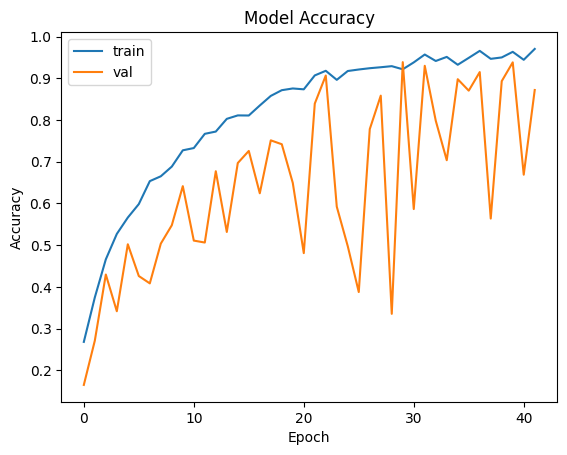

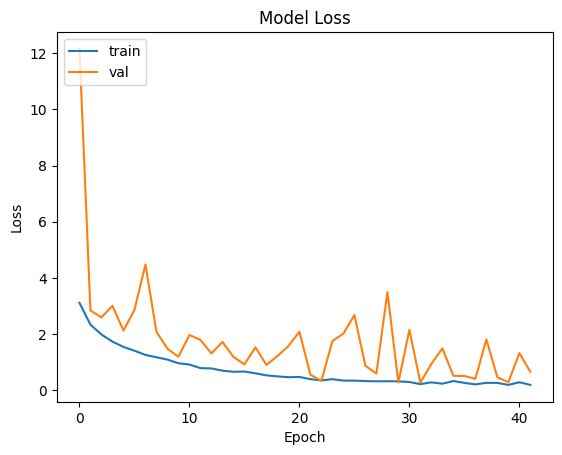

In [18]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
def get_mfcc_spectrogram(audio_path, output_dir):
    y, sr = librosa.load(audio_path, sr=None, duration=4, mono=True, res_type='kaiser_fast')
    y = librosa.effects.trim(y, top_db=20)[0]
    y = librosa.util.normalize(y)
    ft = np.abs(librosa.stft(y))
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(ft), n_mfcc=20)

    fig, ax = plt.subplots()
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax)
    ax.set(title='MFCC Spectrogram', xlabel='Time', ylabel='MFCC')
    image_path = os.path.join(output_dir, os.path.basename(audio_path)[:-4] + '.png')
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    return image_path

In [27]:
audio_path = 'car.wav'
output_dir = '/home/msc1/Desktop/ASB /'
image_path = get_mfcc_spectrogram(audio_path, output_dir)

### ResNet 1 Predictions

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Load the image
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)

# Preprocess the image
image /= 255.0
image = np.expand_dims(image, axis=0)

# Make a prediction using the model
prediction = model.predict(image)

# Assuming the prediction output is stored in the variable 'prediction'
predicted_class = np.argmax(prediction)

# To get the name of the predicted class, you can use the 'class_indices' attribute of the generator used for inference
class_names = list(train_generator.class_indices.keys())
predicted_class_name = class_names[predicted_class]

print(predicted_class_name)

gun


### ResNet 2 Predictions

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Load the image
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)

# Preprocess the image
image /= 255.0
image = np.expand_dims(image, axis=0)

# Make a prediction using the model
prediction = model2.predict(image)

# Assuming the prediction output is stored in the variable 'prediction'
predicted_class = np.argmax(prediction)

# To get the name of the predicted class, you can use the 'class_indices' attribute of the generator used for inference
class_names = list(train_generator.class_indices.keys())
predicted_class_name = class_names[predicted_class]

print(predicted_class_name)

dog


In [30]:
audio_path = 'gun_1.wav'
output_dir = '/home/msc1/Desktop/ASB /'
image_path = get_mfcc_spectrogram(audio_path, output_dir)

### ResNet 1 Predictions

In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Load the image
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)

# Preprocess the image
image /= 255.0
image = np.expand_dims(image, axis=0)

# Make a prediction using the model
prediction = model.predict(image)

# Assuming the prediction output is stored in the variable 'prediction'
predicted_class = np.argmax(prediction)

# To get the name of the predicted class, you can use the 'class_indices' attribute of the generator used for inference
class_names = list(train_generator.class_indices.keys())
predicted_class_name = class_names[predicted_class]

print(predicted_class_name)

gun


### ResNet 2 Predictions 

In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Load the image
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)

# Preprocess the image
image /= 255.0
image = np.expand_dims(image, axis=0)

# Make a prediction using the model
prediction = model2.predict(image)

# Assuming the prediction output is stored in the variable 'prediction'
predicted_class = np.argmax(prediction)

# To get the name of the predicted class, you can use the 'class_indices' attribute of the generator used for inference
class_names = list(train_generator.class_indices.keys())
predicted_class_name = class_names[predicted_class]

print(predicted_class_name)

gun


# 4 - DISCUSSION

#### Throughout my research, I aimed to develop a machine learning model that can accurately detect instances of antisocial behavior, with a specific focus on identifying instances of gun sounds. My experimentation with various models and hyperparameters led me to conclude that ResNet models generally outperformed ANN models, particularly in detecting gun sounds.

#### However, during my experimentation, I also discovered that my second ANN model performed better than the first. This underscores the importance of fine-tuning hyperparameters and exploring different architectures. With some modifications to my models' architecture and hyperparameters, I was able to achieve better accuracy and performance, particularly in identifying the gun sound class.

#### Although audio processing and classification presented significant challenges, I was able to achieve a remarkable level of efficiency and accuracy with my models. By utilizing basic processing techniques, I developed a model capable of accurately identifying instances of antisocial behavior. The implications for such a model in real-world applications, such as crime prevention and public safety, could be immense.

#### However, it's essential to note that my models weren't flawless, and there were instances where they failed to correctly classify audio signals. Audio classification often poses a common challenge, and we shouldn't expect models to identify every instance of antisocial behavior with 100% accuracy. Nevertheless, the high overall accuracy of my models suggests that they could be a valuable tool for identifying and preventing instances of antisocial behavior, particularly when used in conjunction with other surveillance and crime prevention measures.

#### In conclusion, my project highlights the power of machine learning and deep learning techniques for audio classification, particularly in detecting instances of antisocial behavior. While there's room for improvement and refinement, my results suggest that these techniques could have important applications in fields such as public safety and crime prevention. Additionally, further research could explore integrating other types of data, such as visual or text data, to improve model accuracy and detection.